### Importing libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.layers import BatchNormalization, GlobalAveragePooling2D
print(tf.__version__)

2.9.0


### Importing data and Preprocessing

In [2]:
data_path = "Orchid_data/"

In [3]:
def read_species_label(): #reading 156 species variety and their corresponding labels
    with open(data_path + "/readme.txt", 'r') as f: #for reading lines 
        lines = f.readlines()
    species = lines[122:]
    species_var ={}
    for species_name in species:
        index, species_name = species_name.rstrip('\n').split("\t")
        species_name = species_name.rstrip('\xa0')
        index = int(index)
        species_var[index] = species_name

    return species_var

In [4]:
species_var = read_species_label()
#species_var

In [5]:
#funtion to read data from both the files  "Number of flowers" and "Class Species"
def parse_txt_file(file_path):
    df = pd.read_csv(file_path, header=None, dtype=str)
    col = ["Image_name","Species_Class"]
    df.columns = col
    return df

def parse_flowers(file_path):
    df = pd.read_csv(file_path, header=None, dtype=str)
    col = ["Image_name","Num_Flowers"]
    df.columns = col
    return df

In [6]:
def read_data(species_path, flowers_path): #function to merge files so that we
    #can have image_name,num_flowers and Species_class in one dataframe
    temp1_train_df = parse_txt_file(data_path + species_path)
    species_labels  = {k:v for k,v in zip(temp1_train_df['Image_name'],temp1_train_df['Species_Class'])}

    temp2_train_df = parse_flowers(data_path + flowers_path)
    flower_labels  = {k:v for k,v in zip(temp2_train_df['Image_name'],temp2_train_df['Num_Flowers'])}

    k1 = set(species_labels.keys())
    k2 = set(flower_labels.keys())
    common_image_names = list(k1.intersection(k2))

    d = {'Image_name': common_image_names , 
         'Num_Flowers': [flower_labels[k] for k in common_image_names] , 
         'Species_Class':[species_labels[k] for k in common_image_names]}
    df = pd.DataFrame(d)
    return df

In [7]:
train_df = read_data(
    species_path = "/Species_Classifier/Training_Data_for_Species.txt", 
    flowers_path = "/Number of Flower Classifier/Training_Data_for_Number_of_Flower.txt"
)
train_df.head()

,Image_name,Num_Flowers,Species_Class
0,6348.jpg,1,133
1,397.jpg,1,11
2,1552.jpg,3,27
3,1360.jpg,1,24
4,1826.jpg,1,29


In [8]:
train_df['Species_Class'] = train_df['Species_Class'].astype('int')
train_df['Species_Class'] = train_df['Species_Class'] -1
train_df['Num_Flowers'] = train_df['Num_Flowers'].astype('int')
train_df['Num_Flowers'] = train_df['Num_Flowers'] - 1

In [9]:
val_df = read_data(
    species_path = "/Species_Classifier/Validation_Data_for_Species.txt", 
    flowers_path = "/Number of Flower Classifier/Validation_Data_for_Number_of_Flower.txt"
)
val_df.head()

,Image_name,Num_Flowers,Species_Class
0,4381.jpg,1,89
1,4565.jpg,2,94
2,2873.jpg,1,50
3,983.jpg,2,19
4,1704.jpg,3,27


In [10]:

val_df['Species_Class'] = val_df['Species_Class'].astype('int')
val_df['Species_Class'] = val_df['Species_Class'] -1
val_df['Num_Flowers'] = val_df['Num_Flowers'].astype('int')
val_df['Num_Flowers'] = val_df['Num_Flowers'] - 1

### Data Augmentation
We are creating a function named ```prepare_data_pipeline``` which prepares data generators for training and validation datasets. The data generators are created using ```ImageDataGenerator``` class from Keras, which allows data augmentation and preprocessing to be applied to the images.

In [11]:
def prepare_data_pipeline(
    rescale=None, preprocessing_fn=None, target_size=(32, 32)
):
    train_image_gen = ImageDataGenerator(
        rescale=rescale,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        preprocessing_function=preprocessing_fn
    )
    
    valid_image_gen = ImageDataGenerator(
        rescale=rescale, preprocessing_function=preprocessing_fn
    )
    
    train_df['Species_Class'] = train_df['Species_Class'].astype(int)
    train_df['Num_Flowers'] = train_df['Num_Flowers'].astype(int)

    train_generator = train_image_gen.flow_from_dataframe(
    dataframe = train_df,
    directory = data_path + "/Orchid_Images",
    x_col="Image_name",
    y_col=["Species_Class", "Num_Flowers"],
    subset=None,
    batch_size=32,
    seed=123,
    shuffle=True,
    class_mode="multi_output",
    target_size=target_size)

    val_df['Species_Class'] = val_df['Species_Class'].astype(int)
    val_df['Num_Flowers'] = val_df['Num_Flowers'].astype(int)
    
    valid_generator = valid_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_path + "/Orchid_Images",
    x_col="Image_name",
    y_col=["Species_Class", "Num_Flowers"],
    subset=None,
    batch_size=32,
    class_mode="multi_output",
    target_size=target_size)
    
    return train_generator, valid_generator

Preparing the data pipeline for the model by rescaling input images 
to a range between 0 and 1 and creating training and validation data generators.

In [12]:
train_generator, valid_generator = prepare_data_pipeline(rescale=1./255)


Found 5119 validated image filenames.
Found 1235 validated image filenames.


### Building multitask model

This code defines a multi-task convolutional neural network (CNN) which takes as input images of shape (32, 32, 3) and outputs two predictions 
- one for the species of flower in the image and 
- one for the number of flowers in the image.

The CNN architecture consists of several convolutional layers followed by batch normalization and max pooling, which extract features from the input images. These features are then passed through several residual blocks, each consisting of two convolutional layers with batch normalization, which allow the model to learn more complex representations of the input images.

In [13]:
def multi_task_model(shape=(32, 32, 3)):
    inputs = keras.Input(shape=shape, name="img")
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = keras.layers.BatchNormalization() (x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = keras.layers.BatchNormalization() (x)
    block_1_output = layers.MaxPooling2D(3)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
    x = keras.layers.BatchNormalization() (x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = keras.layers.BatchNormalization() (x)
    block_2_output = layers.add([x, block_1_output])

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
    x = keras.layers.BatchNormalization() (x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = keras.layers.BatchNormalization() (x)
    block_3_output = layers.add([x, block_2_output])

    x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
    x = keras.layers.BatchNormalization() (x)
    conv_feat = layers.GlobalAveragePooling2D()(x)
    
    #Species classification head
    x = layers.Dense(256, activation="relu")(conv_feat)
    x = layers.Dropout(0.5)(x)
    outputs_species = layers.Dense(156,activation="softmax", name='outputs_species')(x)
    
    #Num of flowers classification head
    y = layers.Dense(128, activation="relu")(conv_feat)
    y = layers.Dropout(0.5)(y)
    outputs_flowers = layers.Dense(3, activation="softmax", name='outputs_flowers')(y)

    model = keras.Model(inputs, outputs=[outputs_species, outputs_flowers], name="multi_task_model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=['sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
        loss_weights=[5.0, 1.0], 
        metrics=['accuracy']
    )
    
    model.summary()
    return model
    
    

We have considered number of flowers as categorical output as the description in the data is as below:

Number of Flower:
- A Few
-  Many
- SinglePair

Also, we have given the weights higher for species classification than number of flowers because species class have 156 category and we believe it will be harder than 3 category classification for number of flowers

In [14]:
model = multi_task_model(shape=(32, 32, 3))

Model: "multi_task_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 30, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['batch_normalizat

### Model Architecture :
The code below generates a visualization of the Keras model architecture and saves it as a PNG image file with shapes of input/output tensors displayed.The resulting plot aids in debugging and identifying architecture issues.

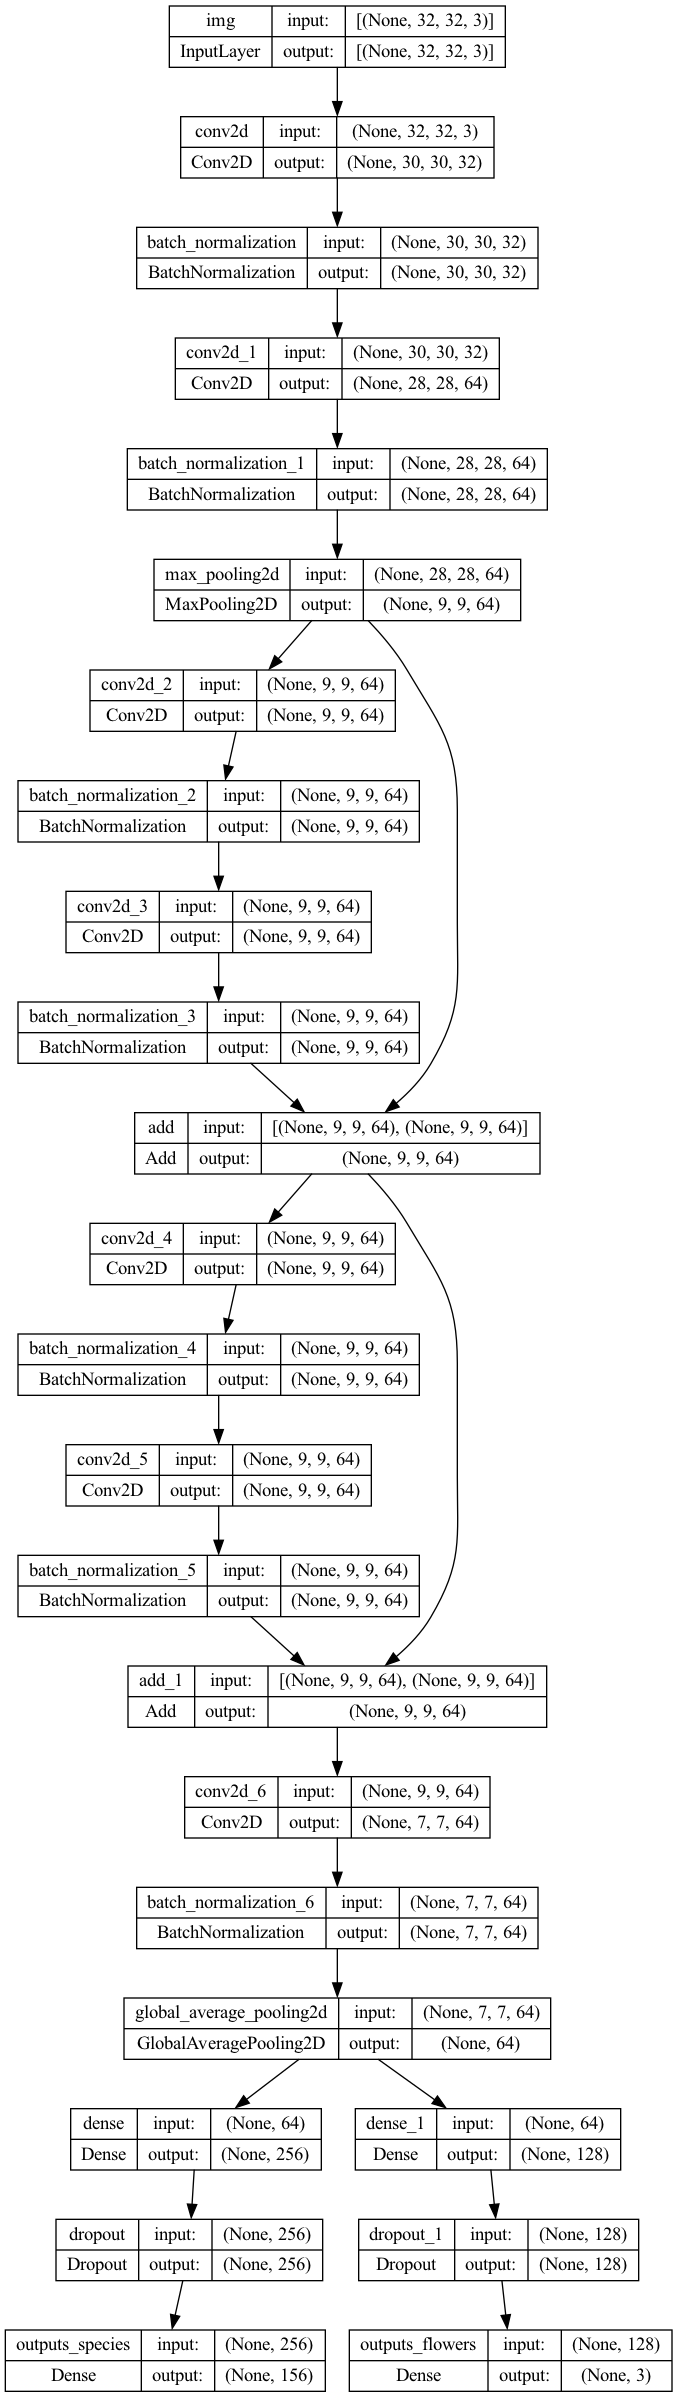

In [15]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

### Model fitting :
The function below trains a Keras model using ```train_gen``` and validates using ```valid_gen```, then returns the trained model and history.

In [16]:
def fit_model(model, train_gen, valid_gen, num_epochs=50): 
    
    print("\nTraining model")
    model.reset_states()
    m_history = model.fit(
      x=train_gen, validation_data=valid_gen, epochs=num_epochs, verbose=1
    )

    print("\n")
    print("=====================")

    return model, m_history

In [17]:
model, m_history = fit_model(
    model, train_gen=train_generator, valid_gen=valid_generator, num_epochs=100
)


Training model
Epoch 1/100
160/160 [==============================] - 14s 80ms/step - loss: 25.4344 - outputs_species_loss: 4.8610 - outputs_flowers_loss: 1.1295 - outputs_species_accuracy: 0.0522 - outputs_flowers_accuracy: 0.3632 - val_loss: 25.2731 - val_outputs_species_loss: 4.8358 - val_outputs_flowers_loss: 1.0943 - val_outputs_species_accuracy: 0.0227 - val_outputs_flowers_accuracy: 0.4632
Epoch 2/100
160/160 [==============================] - 11s 72ms/step - loss: 23.3867 - outputs_species_loss: 4.4627 - outputs_flowers_loss: 1.0733 - outputs_species_accuracy: 0.0897 - outputs_flowers_accuracy: 0.4358 - val_loss: 24.5760 - val_outputs_species_loss: 4.6805 - val_outputs_flowers_loss: 1.1733 - val_outputs_species_accuracy: 0.0283 - val_outputs_flowers_accuracy: 0.4688
Epoch 3/100
160/160 [==============================] - 11s 66ms/step - loss: 22.0491 - outputs_species_loss: 4.1956 - outputs_flowers_loss: 1.0713 - outputs_species_accuracy: 0.1112 - outputs_flowers_accuracy: 0.45

### Plotting the model:
This function is used to plot the training and validation loss for multiple models on the same plot. The resulting plot shows how the loss changes over time for each model, allowing for easy comparison. The x-axis shows the number of epochs, while the y-axis shows the value of the loss. The function also allows for customization of the y-axis limits (ylim) and the legend labels for each model.

In [18]:
def plot_history_models(histories, key='loss', ylim=[0, 1]):
    plt.figure(figsize=(7,5), dpi=150)
    for name, history in histories:
        val = plt.plot(
            history.epoch, history.history['val_' + key], '--', label=name.title() +' Val'
        )
        plt.plot(
            history.epoch, history.history[key], color=val[0].get_color(), label=name.title() +' Train'
        )

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.ylim(ylim)
    plt.grid()

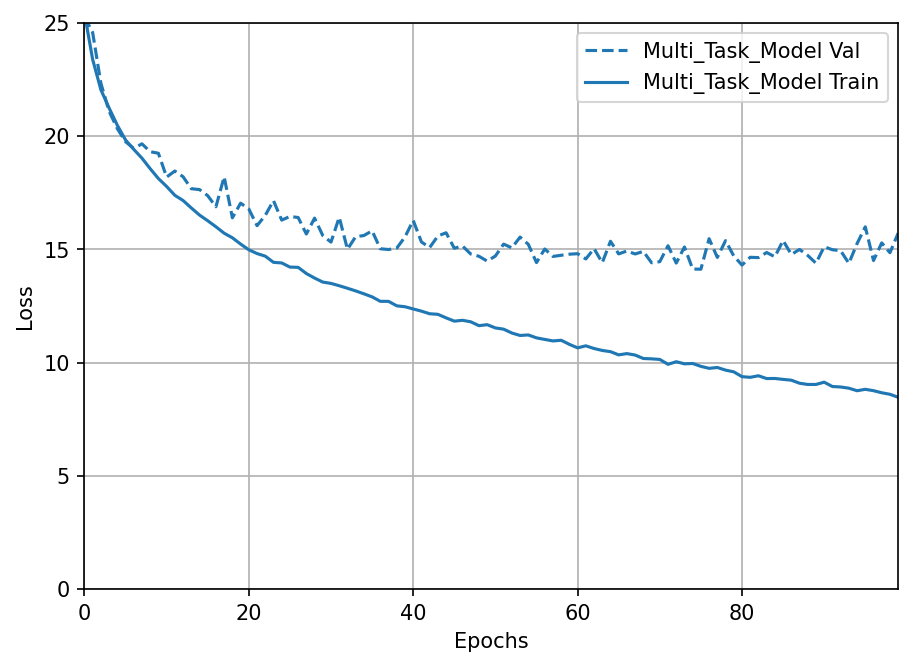

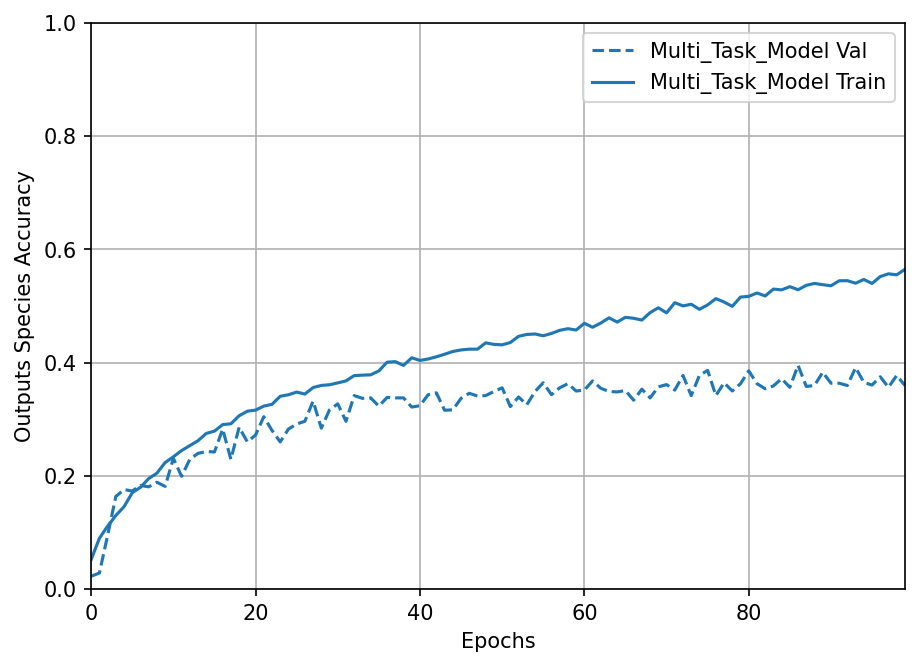

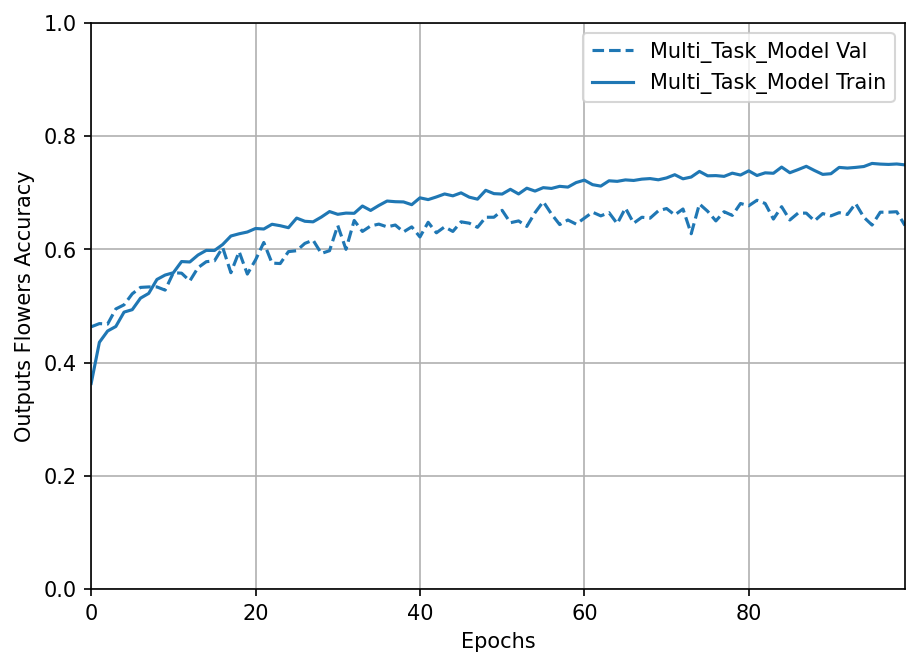

In [19]:
plot_history_models([('multi_task_model', m_history)], key='loss', ylim=[0, 25.0])

plot_history_models([('multi_task_model', m_history)], key='outputs_species_accuracy', ylim=[0, 1.0])
plot_history_models([('multi_task_model', m_history)], key='outputs_flowers_accuracy', ylim=[0, 1.0])

We trained the model for 100 epochs: <br>
- Overall Loss : From the loss plot we can see that the training data loss is decreasing whereas the validation data loss saturates and start increasing.
    
- Outputs_Species_accuracy : We can see from the plot that the validation accuracy is around ~40 % and training accuracy around ~60% which is a clear case of overfitting.
    
- Output_Flowers Accuracy : We can see from the plot that the validation accuracy is around ~65 % and this is better in prediction in compared to Outputs_Species. However, comparing it to its training accuracy,we can see that this is overfitting too.

We can also try different ways to reduce model overfitting by following:
1. Applying data augmentation
2. Using dropouts
3. Using Transfer Learning
4. Adding regularization L1 and L2
5. Reducing the complexity of the model

We have already used 1 & 2 i.e data augmentation and dropouts in our model above. We would like to see if transfer learning improves the model and reduces overfitting.

### Multitask model from transfer learning

This is a transfer learning multi-task model for image classification that predicts the species and number of flowers in an input image. The model uses ```ResNet50V2``` as the base model with frozen weights and has separate dense layers for the two outputs. It uses sparse categorical cross-entropy loss and **Adam** optimizer with a learning rate of **1e-4**. The species classification task is prioritized with a weight of 5.0 as above. The model is compiled with two outputs and returns a summary of its architecture.

In [24]:
def transfer_learn_model(input_shape=(32, 32, 3)):
    inputs = keras.Input(shape=input_shape, name="img")
    base_model = tf.keras.applications.ResNet50V2(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet')
    base_model.trainable = False
    x = base_model(inputs)
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = keras.layers.BatchNormalization() (x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = keras.layers.BatchNormalization() (x)
    block_1_output = layers.MaxPooling2D(3)(x)
    
    x = layers.Conv2D(64, 3, activation="relu")(block_1_output)
    x = keras.layers.BatchNormalization() (x)
    conv_feat = layers.GlobalAveragePooling2D()(x)
    
    #Species classification head
    x = layers.Dense(256, activation="relu")(conv_feat)
    x = layers.Dropout(0.5)(x)
    outputs_species = layers.Dense(156,activation="softmax", name='outputs_species')(x)
    
   #Num of flowers classification head
    y = layers.Dense(128, activation="relu")(conv_feat)
    y = layers.Dropout(0.5)(y)
    outputs_flowers = layers.Dense(3, activation="softmax", name='outputs_flowers')(y)

    model_tl = keras.Model(inputs, outputs=[outputs_species, outputs_flowers], name="multi_task_model")
    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=['sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
        loss_weights=[5.0, 1.0], 
        metrics=['accuracy']
    )
    
    #model_tl.summary()
    return model_tl
    
    
    

The ```ResNet50V2``` model used in ```transfer_learn_model()``` takes an input shape of (224, 224, 3) representing an RGB image with dimensions of 224x224

In [25]:
model_tl = transfer_learn_model(input_shape=(224, 224, 3))


### Plotting Model Arichtecture

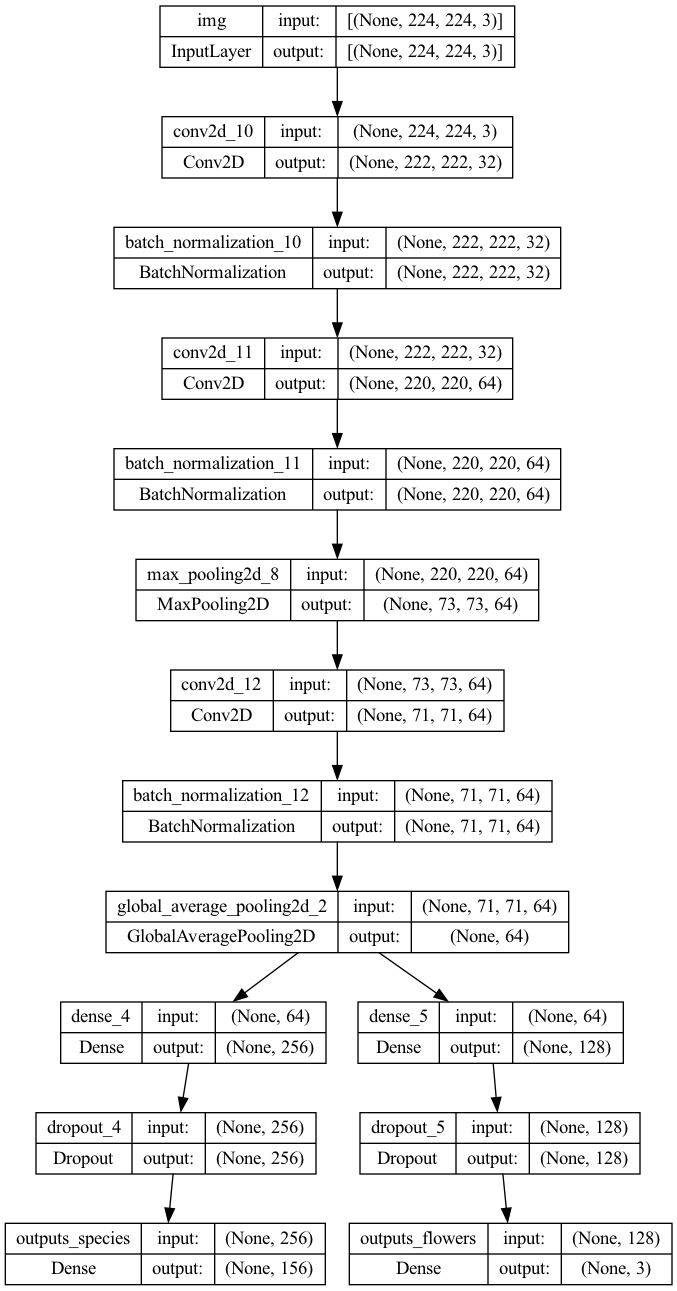

In [26]:
keras.utils.plot_model(model_tl, "model.png", show_shapes=True)

In [27]:
train_generator, valid_generator = prepare_data_pipeline(
    preprocessing_fn=tf.keras.applications.resnet_v2.preprocess_input,
    target_size=(224, 224)
)

model_tl, m_history_tl = fit_model(
    model_tl, train_gen=train_generator, valid_gen=valid_generator, num_epochs=100
)

Found 5119 validated image filenames.
Found 1235 validated image filenames.

Training model
Epoch 1/100
160/160 [==============================] - 81s 501ms/step - loss: 25.5249 - outputs_species_loss: 4.8814 - outputs_flowers_loss: 1.1177 - outputs_species_accuracy: 0.0391 - outputs_flowers_accuracy: 0.3766 - val_loss: 25.5326 - val_outputs_species_loss: 4.8952 - val_outputs_flowers_loss: 1.0565 - val_outputs_species_accuracy: 0.0275 - val_outputs_flowers_accuracy: 0.4632
Epoch 2/100
160/160 [==============================] - 85s 529ms/step - loss: 23.8504 - outputs_species_loss: 4.5556 - outputs_flowers_loss: 1.0722 - outputs_species_accuracy: 0.0852 - outputs_flowers_accuracy: 0.4296 - val_loss: 24.2183 - val_outputs_species_loss: 4.6324 - val_outputs_flowers_loss: 1.0562 - val_outputs_species_accuracy: 0.0372 - val_outputs_flowers_accuracy: 0.4543
Epoch 3/100
160/160 [==============================] - 84s 524ms/step - loss: 22.5691 - outputs_species_loss: 4.3025 - outputs_flowers_l

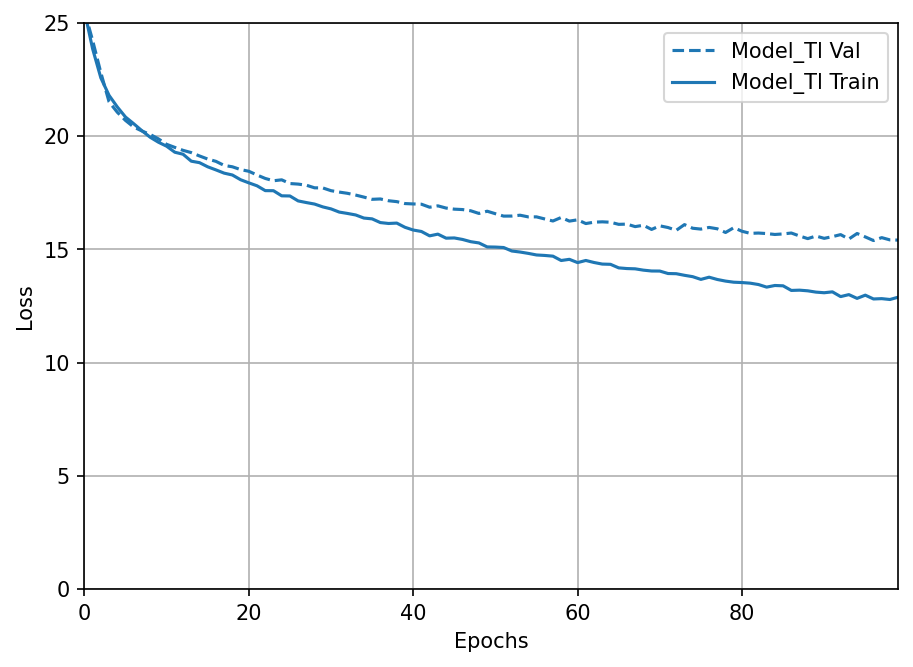

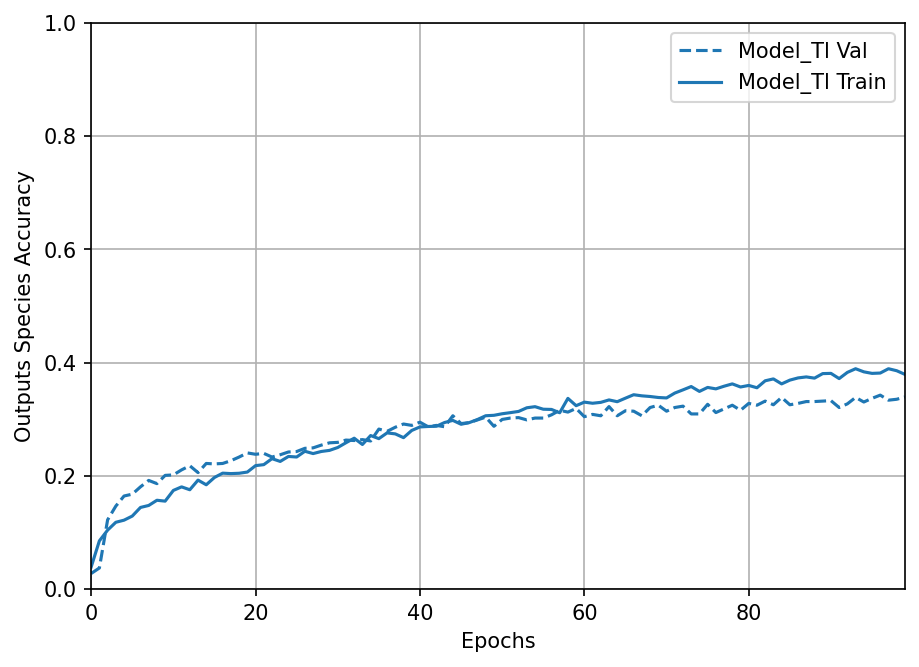

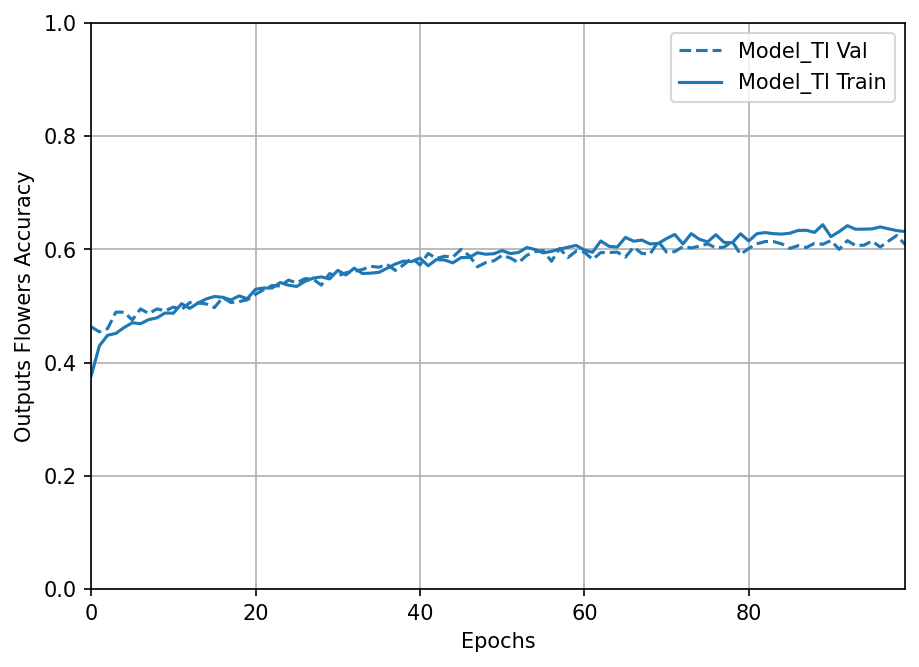

In [28]:
plot_history_models([('Model_tl', m_history_tl)], key='loss', ylim=[0, 25.0])

plot_history_models([('Model_tl', m_history_tl)], key='outputs_species_accuracy', ylim=[0, 1.0])
plot_history_models([('Model_tl', m_history_tl)], key='outputs_flowers_accuracy', ylim=[0, 1.0])

From the above plot, we can see that we have  successfully reduced overfitting by using transfer learning for both Outputs Flower and Output Species when compared to our initial multitask model. Transfer learning has slightly higher accuracy compared to the previous model.

Also, we noticed from train and validation loss plot that the model has not converged yet.And therefore, training it for more than 100 epochs will likely give a better model achieveing even higher accuracy.Due to resource constraint, we train this model for only 100 epochs